# import

In [1]:
import sys
sys.path.append("./src")
from src.data_storage import ngs_path_collection, virus_seqs, random_mutant_dataset
from src.bio_utils import seqlogo_from_msa
import logomaker as lm
# from src.sequencing_analysis_utils import ngs_expr_set 
from src.ngs_analysis import ngs_expr_set, ngs_expr
from src.sec_structure import natr_struc
from src.utils import save_fig, defaultStyle
import pandas as pd
import logomaker as lm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
import RNA
from scipy.stats import pearsonr, ttest_ind
import math
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.metrics import r2_score
from itertools import product
import subprocess

import torch
import os
from src.model_config import ModelConfig, model_collections
from src.data_storage import random_mutant_dataset, virus_seqs
import data
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from pathlib import Path
from scipy.stats import pearsonr, mode
from math import sqrt, floor, ceil
from tqdm import tqdm
from collections import Counter
defaultStyle(fs=18)
import warnings
warnings.filterwarnings("ignore")

from upsetplot import plot
import umap as umap
from Bio import Seq, SeqIO
import re
from src.bio_utils import GFFReader, exportMultiAlignment, muscle, parseHMMout, WriteSeqs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.stats
from scipy.spatial import distance


virus_name, date = 'VEE', '0412'
print(f"Analysis of {virus_name} sequencing data on {date}")
ngs = ngs_expr_set(virus_name, date, downstream_seq_len=7)
original_seq = virus_seqs(virus_name).original_seq
downstream_seq  = virus_seqs(virus_name).downstream_seq 
original_seq_counts_df = pd.DataFrame(columns=['A', 'C', 'G', 'T'])

Analysis of VEE sequencing data on 0412


## generate input

In [6]:
def substitution(seq, i, target):
    seq_arr = list(seq)
    seq_arr[i] = target
    return "".join(seq_arr)

data_df = pd.read_csv('../data/metadata/alphavirus_strain_tol.csv')
data_df = pd.read_csv('./data/VEE_0629.csv')
data_df = data_df[data_df.distance == 0]
data_df = data_df.reset_index(drop=True)
def replace_by_index(string, index, new_character):
    string_list = list(string)
    string_list[index] = new_character
    updated_string = ''.join(string_list)
    return updated_string
list_tol = []
for ndx in range(0,len(data_df)):
    original_seq = data_df.loc[ndx,'seq']
    original_seq = replace_by_index(original_seq, 2, 'A')
    seqs = []
    for idx in range(0,44):
        symbol = set("ATGC")
        muti_list = list(symbol - {original_seq[idx]})
        subsi = [substitution(original_seq, idx, target) for target in muti_list]
        seqs.append(subsi)

    seq_df = pd.DataFrame(
                    columns=["seq","score"]
                )
    seqs = [x for item in seqs for x in item]
    seqs.append(original_seq)

    seq_df['seq'] = pd.DataFrame(seqs)
    seq_df = seq_df.drop_duplicates(subset=['seq'])
    seq_df.reset_index(inplace=True,
                    drop=True)
    seq_df.to_csv("./data/VEE_0816_volvability.csv",
                index=False)

    model_name = "deepcnnlstm"
    mconf = ModelConfig(model_name)
    model = model_collections[model_name](mconf)

    model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
    model.eval()
    test_path = f"./data/VEE_0816_volvability.csv"
    data_size = len(pd.read_csv(test_path))
    if model_name == "bert":
        test_data = data.BERTDataset(test_path)
    else:
        test_data = data.NormalDataset(test_path)
    loader = DataLoader(test_data, batch_size=data_size)

    # Forward the test set
    with torch.no_grad():
        for batch in loader:
            out, loss = model(*batch)
    out = out.cpu().numpy()

    seq_df['score'] = pd.DataFrame(out)
    ori_score = seq_df.tail(1).loc[:,'score']

    array_ndx = np.array(seq_df['score'])
    array_ndx = array_ndx - array_ndx[-1]
    array_ndx = array_ndx[:-1]
    array_ndx = np.sort(array_ndx).tolist()
    
    list_tol.append(array_ndx)

array_tol = np.array(list_tol)
array_tol
# np.save("./data/VEE_neibor_0816_volvability.npy", {"X": array_tol})

array([[-5.65163279e+00, -5.41663265e+00, -4.84188652e+00,
        -4.79364252e+00, -4.60450459e+00, -4.51950169e+00,
        -4.18787384e+00, -3.10936689e+00, -2.33505869e+00,
        -2.26704550e+00, -2.08155775e+00, -1.97689950e+00,
        -1.96116817e+00, -1.89783347e+00, -1.85518897e+00,
        -1.69802415e+00, -1.60624218e+00, -1.58849716e+00,
        -1.45324767e+00, -1.38967538e+00, -1.38384354e+00,
        -1.36867392e+00, -1.33643746e+00, -1.32654214e+00,
        -1.27829564e+00, -1.26851273e+00, -1.22634411e+00,
        -1.19393826e+00, -1.10860884e+00, -1.09340048e+00,
        -1.05229080e+00, -9.81434941e-01, -9.80124474e-01,
        -9.32533741e-01, -9.22389507e-01, -8.89764547e-01,
        -8.70894194e-01, -7.96566010e-01, -7.21260548e-01,
        -6.71993494e-01, -6.38612986e-01, -5.99322319e-01,
        -5.09168386e-01, -5.08144855e-01, -5.01759052e-01,
        -4.19492006e-01, -4.18062925e-01, -4.06284809e-01,
        -4.03893948e-01, -3.68321896e-01, -3.48830223e-0

Saving figure robust_G3A


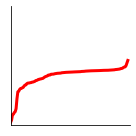

In [8]:
_, ax = plt.subplots(1, 1, figsize=(2,2))
ax.plot(range(0,132), array_tol.transpose(), c='red', alpha=1,linewidth=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,133])
ax.set_ylim([-6,7])
ax.set_xticks([])
ax.set_yticks([])
save_fig('robust_G3A')


## add the score

In [9]:
data_df = pd.read_csv('../data/metadata/alphavirus_strain_tol.csv')
print(len(data_df))
data_df['score'] = 0
# other_df = pd.read_csv('../data/metadata/alphavirus_strain_tol.csv')
# data_df = pd.concat([data_df,other_df],axis=0)
# data_df.reset_index(drop=True,inplace=True)
data_df.to_csv("./data/VEE_0816_volvability.csv",
                index=False)

model_name = "deepcnnlstm"
mconf = ModelConfig(model_name)
model = model_collections[model_name](mconf)

model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
model.eval()
test_path = f"./data/VEE_0816_volvability.csv"
data_size = len(pd.read_csv(test_path))
if model_name == "bert":
    test_data = data.BERTDataset(test_path)
else:
    test_data = data.NormalDataset(test_path)
loader = DataLoader(test_data, batch_size=data_size)

# Forward the test set
with torch.no_grad():
    for batch in loader:
        out, loss = model(*batch)
out = out.cpu().numpy()

data_df['score'] = pd.DataFrame(out)
array_tol = np.array(data_df['score'])
np.save("./data/VEE_nerbor_0816_score.npy", {"X": array_tol})

269


In [51]:
data_array_nat = np.load("./data/VEE_0816_score.npy", allow_pickle=True).item()
sim_data_ori = data_array_nat["X"]
sim_data_ori[-7:]

array([2.9172711, 1.0620819, 1.0908233, 1.1105789, 0.8709251, 1.0036012,
       0.7231043], dtype=float32)

In [14]:
data_df = pd.read_csv('../data/metadata/alphavirus_strain_tol.csv')
data_df[data_df['seq'] == original_seq]
seq = list(original_seq)
seq[25] = 'A'
seq[30] = 'T'
seq = ''.join(seq)
data_df[data_df['seq'] == seq]

,seqid,seq
59,KC344471-1-Venezuelan-equine-encephalitis-viru...,ATGGGCGGCGCATGAGAGAAGCCCAAACCATTTACCTACCCAAA


## generate robust library

In [10]:
df1 = pd.read_csv('../data/sequencing/220905/Cleandata/VEE-0905-l1.csv') 
df2 = pd.read_csv('../data/sequencing/220905/Cleandata/VEE-0905-l2.csv') 
df3 = pd.read_csv('../data/sequencing/220905/Cleandata/VEE-0905-l3.csv') 
df = pd.concat([df1,df2,df3])
df = df.drop_duplicates(subset='seq')
df = df.reset_index(drop=True)
df

,seqid,seq,plasmid_counts,length,plasmid_freq,rna_counts,rna_freq,score,distance
0,14842,ATGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,286,44,0.000163,70,4.563195e-05,-1.275342,0
1,16422,ATAGGAGGGCGCTGAGATAGGCCCGAGCCGATTCCCTACCCAAA,74,44,0.000041,1259,8.079551e-04,2.983890,10
2,32508,ATAGGAGGCGGGTGAGATAAGCCCGGGCCGAGTCCCTACCCAAA,164,44,0.000091,2719,1.744901e-03,2.958035,10
3,31004,ATAGGAGGCGGGTGAGATAAGCCCGGGCCGATTTCCTACCCAAA,81,44,0.000045,1201,7.707339e-04,2.846342,9
4,14439,ATAGGAGGCGGGTGAGATAAGCCCGGGCCGATTGCCTACCCAAA,232,44,0.000128,3174,2.036894e-03,2.765892,9
...,...,...,...,...,...,...,...,...,...
34572,19123,CTGTGCCCCGCATCAGAGAAGCCTATACCAATTACCCACCAACA,259,44,0.000134,1,5.617744e-07,-5.474144,10
34573,7722,AGCTGCTTCGGCTGAGTGAGGCCTACGAGATTATAACTCCCGCT,273,44,0.000141,1,5.617744e-07,-5.526788,20
34574,17849,TTTAGGGGGTCAATGTCGCCCCACCGACCTCTTACCTATCGAAG,295,44,0.000153,1,5.617744e-07,-5.604292,20
34575,18251,CTGGGCGGCGCATGAGACAAGCCCAGACCACTTACCCAGCCAAA,310,44,0.000160,1,5.617744e-07,-5.653889,5


In [11]:
df = pd.read_csv("./data/VEE_robust_lib_final.csv")
df

,seqid,seq,plasmid_counts,length,plasmid_freq,rna_counts,rna_freq,score,distance,robust_score,pre_score
0,4723,AAGGGGGGCGGATGAGAGAGGCCCGGACCGCTTACCTACCCAAG,37,44,0.000020,182,0.000117,1.742971,8,0.606061,1.835290
1,26029,AAGGGAGGCCGATGAGAGAAGCCCGGCCCGTTTACCTACCCAAG,89,44,0.000049,437,0.000280,1.741179,9,0.545455,1.963950
2,6151,AAGGGGGGCCGATGAGAGAAGCCCCGACCGTGTACCTACCTAAG,68,44,0.000038,297,0.000191,1.624106,10,0.553030,1.730607
3,6414,AAGGGGGGCGCATGAGAGTAGCCCAGACTAACTACCTGCCCTGA,106,44,0.000059,458,0.000294,1.613312,8,0.590909,1.908077
4,9567,AAGGGGGGCGCGTGAGAGACGCCCAGTCCAATTACCTCCGCAAA,106,44,0.000059,455,0.000292,1.606740,7,0.553030,1.969821
...,...,...,...,...,...,...,...,...,...,...,...
6073,12619,AACGGAAGCACTTGAGAAAAGTACCCTCCAATTACCTACACAAG,49,44,0.000025,13,0.000007,-1.244187,14,0.613636,0.363401
6074,17355,AAGGCAATCGGAGGAATAAAGCATATACCTAGTACGCACCCAAA,57,44,0.000029,15,0.000008,-1.252317,17,0.545455,0.371749
6075,13671,GAAAGGGGAGCATAGGGAAAACGCAGACGACTTACCTACCTGAA,68,44,0.000035,17,0.000010,-1.303611,14,0.590909,0.115067
6076,2848,ATGAGAGAAACCTAGCCCACCCCGAGACGGACGGGCGACTCACT,399,44,0.000206,90,0.000051,-1.406468,22,0.560606,0.120115


In [12]:
def substitution(seq, i, target):
    seq_arr = list(seq)
    seq_arr[i] = target
    return "".join(seq_arr)

data_df = df

list_tol = []
for ndx in range(0,len(data_df)):
    original_seq = data_df.loc[ndx,'seq']
    seqs = []
    for idx in range(0,44):
        symbol = set("ATGC")
        muti_list = list(symbol - {original_seq[idx]})
        subsi = [substitution(original_seq, idx, target) for target in muti_list]
        seqs.append(subsi)

    seq_df = pd.DataFrame(
                    columns=["seq","score"]
                )
    seqs = [x for item in seqs for x in item]
    seqs.append(original_seq)

    seq_df['seq'] = pd.DataFrame(seqs)
    seq_df = seq_df.drop_duplicates(subset=['seq'])
    seq_df.reset_index(inplace=True,
                    drop=True)
    seq_df.to_csv("./data/VEE_robust_lib.csv",
                index=False)

    model_name = "deepcnnlstm"
    mconf = ModelConfig(model_name)
    model = model_collections[model_name](mconf)

    model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
    model.eval()
    test_path = f"./data/VEE_robust_lib.csv"
    data_size = len(pd.read_csv(test_path))
    if model_name == "bert":
        test_data = data.BERTDataset(test_path)
    else:
        test_data = data.NormalDataset(test_path)
    loader = DataLoader(test_data, batch_size=data_size)

    # Forward the test set
    with torch.no_grad():
        for batch in loader:
            out, loss = model(*batch)
    out = out.cpu().numpy()

    seq_df['score'] = pd.DataFrame(out)
    ori_score = seq_df.tail(1).loc[:,'score']

    array_ndx = np.array(seq_df['score'])
    array_ndx = array_ndx - array_ndx[-1]
    array_ndx = array_ndx[:-1]
    array_ndx = np.sort(array_ndx).tolist()
    
    list_tol.append(array_ndx)

array_tol = np.array(list_tol)
# calculate robustness
robust_thr = 0.1
robust_score = []
for adx in range(array_tol.shape[0]):
    mid = abs(array_tol[adx])
    count = 0
    for num in mid:
        if num < robust_thr:
            count +=1
    robust_score.append(count / array_tol.shape[1])
print(np.max(robust_score))
score_df = pd.DataFrame(robust_score,columns=['robust_score'])
score_df.to_csv('./data/robust_score_select.csv',index=None)
np.save("./data/VEE_robust_lib_select.npy", {"X": array_tol})

0.803030303030303


-4.120354175567627
0.23223257064819336


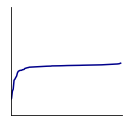

In [15]:
_, ax = plt.subplots(1, 1, figsize=(2,2))
n_data = 904
ax.plot(range(0,132), array_tol[n_data], c='darkblue', alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,133])
ax.set_ylim([-6,7])
ax.set_xticks([])
ax.set_yticks([])
# save_fig('robust_most')
print(array_tol[n_data].min())
print(array_tol[n_data].max())

In [14]:
array_tol

array([[-3.7674942 , -3.74427605, -2.99961376, ...,  0.18369722,
         0.2016573 ,  0.32051063],
       [-4.12035418, -3.97801447, -3.12186074, ...,  0.15624309,
         0.19281602,  0.23223257],
       [-3.96642971, -3.90871429, -3.22559834, ...,  0.14364088,
         0.17030632,  0.18946385],
       ...,
       [-2.10829759, -2.00101042, -1.71501493, ...,  0.32459575,
         0.42944226,  0.91482562],
       [-3.31311226, -3.01628971, -2.6128149 , ...,  0.29056069,
         0.39755806,  1.54802513],
       [-2.80854297, -2.13762903, -2.02778053, ...,  0.3583236 ,
         0.98505735,  1.02290046]])

In [6]:
df1.to_csv("./data/VEE_robust_lib.csv",
                index=False)

model_name = "deepcnnlstm"
mconf = ModelConfig(model_name)
model = model_collections[model_name](mconf)

model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
model.eval()
test_path = f"./data/VEE_robust_lib_final.csv"
data_size = len(pd.read_csv(test_path))
if model_name == "bert":
    test_data = data.BERTDataset(test_path)
else:
    test_data = data.NormalDataset(test_path)
loader = DataLoader(test_data, batch_size=data_size)

# Forward the test set
with torch.no_grad():
    for batch in loader:
        out, loss = model(*batch)
out = out.cpu().numpy()

df1['pre_score'] = pd.DataFrame(out)
array_tol = np.array(df1['pre_score'])
np.save("./data/VEE_robust_lib_score.npy", {"X": array_tol})
df1

,seqid,seq,plasmid_counts,length,plasmid_freq,rna_counts,rna_freq,score,distance,robust_score,pre_score,robust_score
0,4723.0,AAGGGGGGCGGATGAGAGAGGCCCGGACCGCTTACCTACCCAAG,37.0,44.0,0.000020,182.0,0.000117,1.742971,8.0,0.606061,1.835290,0.250000
1,26029.0,AAGGGAGGCCGATGAGAGAAGCCCGGCCCGTTTACCTACCCAAG,89.0,44.0,0.000049,437.0,0.000280,1.741179,9.0,0.545455,1.963950,0.151515
2,6151.0,AAGGGGGGCCGATGAGAGAAGCCCCGACCGTGTACCTACCTAAG,68.0,44.0,0.000038,297.0,0.000191,1.624106,10.0,0.553030,1.730607,0.143939
3,6414.0,AAGGGGGGCGCATGAGAGTAGCCCAGACTAACTACCTGCCCTGA,106.0,44.0,0.000059,458.0,0.000294,1.613312,8.0,0.590909,1.908077,0.159091
4,9567.0,AAGGGGGGCGCGTGAGAGACGCCCAGTCCAATTACCTCCGCAAA,106.0,44.0,0.000059,455.0,0.000292,1.606740,7.0,0.553030,1.969821,0.151515
...,...,...,...,...,...,...,...,...,...,...,...,...
34572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.833333
34573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.818182
34574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.681818
34575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667


Saving figure robust_lib_valid


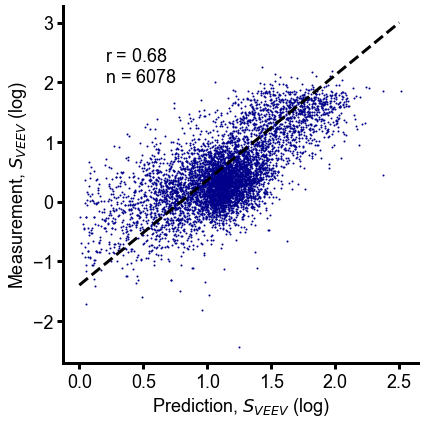

In [20]:
df3 = pd.read_csv("./data/VEE_robust_lib_final.csv")
r2 = r2_score(df3.pre_score, df3.score)
r, p_val = pearsonr(df3.pre_score, df3.score)

_, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(df3.pre_score, 
                df3.score, 
                color='darkblue',
            alpha=1,
            s=1)
ax.plot([0,2.5], [-1.4,3], linewidth=3, ls='--', color='black')
ax.text(0.2,2, "r = $%.2f$\nn = $%.0f$"%(r, len(df3)), fontsize=18)
ax.set_xlabel('Prediction, $S_{VEEV}$ (log)')
ax.set_ylabel('Measurement, $S_{VEEV}$ (log)')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(width=3, length=6) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
save_fig('robust_lib_valid')

## for robust seq

In [19]:
df3 = df3.reset_index(drop=True)
df3.to_csv("./data/VEE_robust_lib_final.csv",index=None)
data_df = pd.read_csv("./data/VEE_robust_lib_final.csv")

In [9]:
def substitution(seq, i, target):
    seq_arr = list(seq)
    seq_arr[i] = target
    return "".join(seq_arr)

list_tol = []
for ndx in range(0,len(data_df)):
    original_seq = data_df.loc[ndx,'seq']
    seqs = []
    for idx in range(0,44):
        symbol = set("ATGC")
        muti_list = list(symbol - {original_seq[idx]})
        subsi = [substitution(original_seq, idx, target) for target in muti_list]
        seqs.append(subsi)

    seq_df = pd.DataFrame(
                    columns=["seq","score"]
                )
    seqs = [x for item in seqs for x in item]
    seqs.append(original_seq)

    seq_df['seq'] = pd.DataFrame(seqs)
    seq_df = seq_df.drop_duplicates(subset=['seq'])
    seq_df.reset_index(inplace=True,
                    drop=True)
    seq_df.to_csv("./data/VEE_robust_lib.csv",
                index=False)

    model_name = "deepcnnlstm"
    mconf = ModelConfig(model_name)
    model = model_collections[model_name](mconf)

    model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
    model.eval()
    test_path = f"./data/VEE_robust_lib.csv"
    data_size = len(pd.read_csv(test_path))
    if model_name == "bert":
        test_data = data.BERTDataset(test_path)
    else:
        test_data = data.NormalDataset(test_path)
    loader = DataLoader(test_data, batch_size=data_size)

    # Forward the test set
    with torch.no_grad():
        for batch in loader:
            out, loss = model(*batch)
    out = out.cpu().numpy()

    seq_df['score'] = pd.DataFrame(out)
    ori_score = seq_df.tail(1).loc[:,'score']

    array_ndx = np.array(seq_df['score'])
    array_ndx = array_ndx - array_ndx[-1]
    array_ndx = array_ndx[:-1]
    array_ndx = np.sort(array_ndx).tolist()
    
    list_tol.append(array_ndx)

array_tol = np.array(list_tol)
# calculate robustness
robust_thr = 0.1
robust_score = []
for adx in range(array_tol.shape[0]):
    mid = abs(array_tol[adx])
    count = 0
    for num in mid:
        if num < robust_thr:
            count +=1
    robust_score.append(count / array_tol.shape[1])
print(np.max(robust_score))
score_df = pd.DataFrame(robust_score,columns=['robust_score'])
score_df.to_csv('./data/robust_score_final.csv',index=None)
np.save("./data/VEE_robust_lib_final.npy", {"X": array_tol})

0.9621212121212122


In [10]:
model_name = "deepcnnlstm"
mconf = ModelConfig(model_name)
model = model_collections[model_name](mconf)

model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
model.eval()
test_path = f"./data/VEE_robust_lib_final.csv"
data_size = len(pd.read_csv(test_path))
if model_name == "bert":
    test_data = data.BERTDataset(test_path)
else:
    test_data = data.NormalDataset(test_path)
loader = DataLoader(test_data, batch_size=data_size)

# Forward the test set
with torch.no_grad():
    for batch in loader:
        out, loss = model(*batch)
out = out.cpu().numpy()
array_tol = np.array(pd.DataFrame(out))
np.save("./data/VEE_robust_lib_score_final.npy", {"X": array_tol})
array_tol

array([[ 1.83529  ],
       [ 1.9639499],
       [ 1.7306068],
       ...,
       [-3.1074502],
       [-2.6763375],
       [-2.9421213]], dtype=float32)